# **DATA SET**
## The Behavioral Risk Factor Surveillance System (BRFSS) data from the CDC includes information about risk factors related to tobacco use, covering the years from 2011 to 2019. This dataset encompasses demographic information and smoking habits.

## Link: https://data.cdc.gov/Survey-Data/Behavioral-Risk-Factor-Data-Tobacco-Use-2011-to-pr/wsas-xwh5/about_data

# **PREDICTION**

## I aim to assess the likelihood of tobacco use based on factors such as age group, gender, race, education level, geographic location, topic descriptions, and survey data values.

# **GOAL**
## The objective is to analyze the **response** column that classifies individuals into categories of tobacco use behavior, such as 'Current,' 'Every Day,' 'Some Days,' 'Former,' 'Never,' 'Not Current,' or 'Unknown.' By uncovering patterns and trends from this data, we can gain valuable insights that inform targeted public health interventions and policies aimed at reducing tobacco use and its associated risks.

In [7]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
# Read the data
df = pd.read_csv('Behavioral_Risk_Factor_Data__Tobacco_Use__2011_to_present__20241123.csv')

df.head()

,YEAR,LocationAbbr,LocationDesc,TopicType,TopicDesc,MeasureDesc,DataSource,Response,Data_Value_Unit,Data_Value_Type,...,GeoLocation,TopicTypeId,TopicId,MeasureId,StratificationID1,StratificationID2,StratificationID3,StratificationID4,SubMeasureID,DisplayOrder
0,2017,GU,Guam,Tobacco Use – Survey Data,Cigarette Use (Adults),Current Smoking,BRFSS,NaN,%,Percentage,...,"(13.444304, 144.793731)",BEH,100BEH,110CSA,2GEN,8AGE,6RAC,6EDU,BRF21,21
1,2018,US,National Median (States and DC),Tobacco Use – Survey Data,Cigarette Use (Adults),Smoking Status,BRFSS,Current,%,Percentage,...,NaN,BEH,100BEH,165SSA,1GEN,8AGE,6RAC,6EDU,BRF27,27
2,2017,US,National Median (States and DC),Tobacco Use – Survey Data,Cigarette Use (Adults),Smoking Status,BRFSS,Never,%,Percentage,...,NaN,BEH,100BEH,165SSA,1GEN,8AGE,6RAC,6EDU,BRF28,28
3,2016,GU,Guam,Tobacco Use – Survey Data,Smokeless Tobacco Use (Adults),Current Use,BRFSS,NaN,%,Percentage,...,"(13.444304, 144.793731)",BEH,150BEH,177SCU,1GEN,8AGE,4RAC,6EDU,BRF69,69
4,2014,GU,Guam,Tobacco Use – Survey Data,Cigarette Use (Adults),Current Smoking,BRFSS,NaN,%,Percentage,...,"(13.444304, 144.793731)",BEH,100BEH,110CSA,1GEN,8AGE,5RAC,6EDU,BRF22,22


In [9]:
# Data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43341 entries, 0 to 43340
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   YEAR                        43341 non-null  object 
 1   LocationAbbr                43341 non-null  object 
 2   LocationDesc                43341 non-null  object 
 3   TopicType                   43341 non-null  object 
 4   TopicDesc                   43341 non-null  object 
 5   MeasureDesc                 43341 non-null  object 
 6   DataSource                  43341 non-null  object 
 7   Response                    15018 non-null  object 
 8   Data_Value_Unit             43341 non-null  object 
 9   Data_Value_Type             43341 non-null  object 
 10  Data_Value                  41224 non-null  float64
 11  Data_Value_Footnote_Symbol  2117 non-null   object 
 12  Data_Value_Footnote         2117 non-null   object 
 13  Data_Value_Std_Err          411

In [10]:
# List of columns to keep
keep_cols = ['Age', 'Gender', 'Race', 'Education', 'LocationDesc', 'TopicId',
             'TopicDesc', 'MeasureId', 'Data_Value', 'Data_Value_Std_Err',
             'Low_Confidence_Limit', 'High_Confidence_Limit',
             'Sample_Size', 'Response']

# Drop columns not in keep_cols
data = df[keep_cols].copy()

# List of numerical columns for outlier detection
numerical_cols = ['Data_Value', 'Data_Value_Std_Err', 'Low_Confidence_Limit', 'High_Confidence_Limit', 'Sample_Size']

# List of categorical columns
categorical_cols = ['Age', 'Gender', 'Race', 'Education', 'LocationDesc', 'TopicId', 'TopicDesc', 'MeasureId']


# Replace NaNs with 'unknown' in categorical columns and 0 in numerical columns
data.loc[:, categorical_cols] = data.loc[:, categorical_cols].fillna('unknown')
data.loc[:, numerical_cols] = data.loc[:, numerical_cols].fillna(0)
data.loc[:, 'Response'] = data.loc[:, 'Response'].fillna('unknown')

# Remove duplicate rows
data.drop_duplicates(subset=keep_cols, keep='first', inplace=True)


data.head()

,Age,Gender,Race,Education,LocationDesc,TopicId,TopicDesc,MeasureId,Data_Value,Data_Value_Std_Err,Low_Confidence_Limit,High_Confidence_Limit,Sample_Size,Response
0,All Ages,Male,All Races,All Grades,Guam,100BEH,Cigarette Use (Adults),110CSA,30.0,2.3,25.4,34.6,692.0,unknown
1,All Ages,Overall,All Races,All Grades,National Median (States and DC),100BEH,Cigarette Use (Adults),165SSA,16.1,0.0,0.0,0.0,0.0,Current
2,All Ages,Overall,All Races,All Grades,National Median (States and DC),100BEH,Cigarette Use (Adults),165SSA,58.2,0.0,0.0,0.0,0.0,Never
3,All Ages,Overall,Hispanic,All Grades,Guam,150BEH,Smokeless Tobacco Use (Adults),177SCU,0.5,0.4,0.0,1.2,123.0,unknown
4,All Ages,Overall,White,All Grades,Guam,100BEH,Cigarette Use (Adults),110CSA,21.9,4.9,12.4,31.4,209.0,unknown


In [11]:
# Target variable count

target_col = 'Response'
data['Response'].value_counts()

,count
Response,
unknown,26993
Current,3295
Some Days,2943
Every Day,2943
Never,1860
Former,1855
Not Current,1436


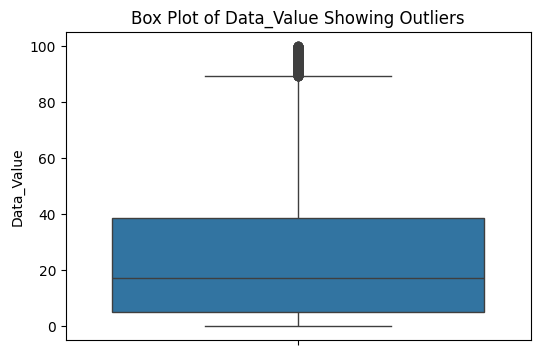

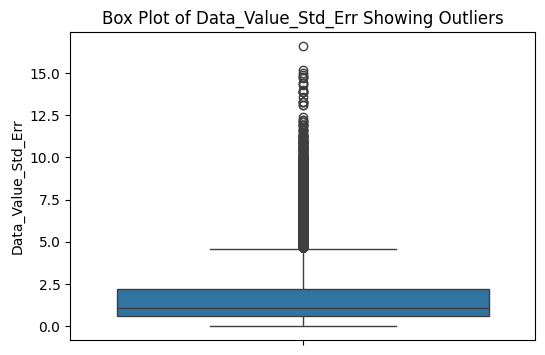

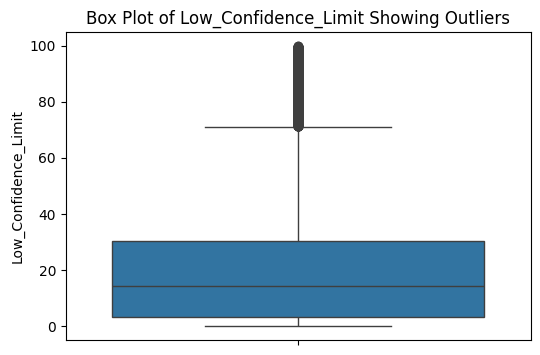

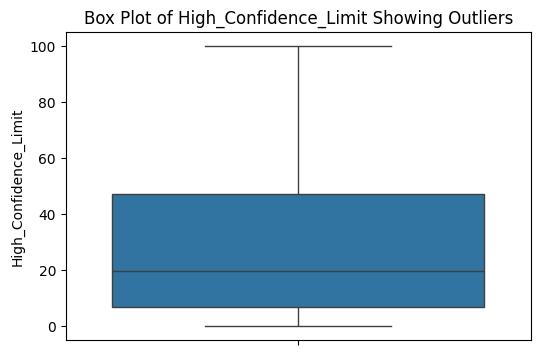

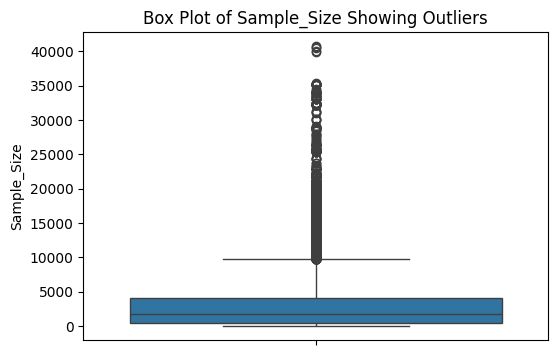

In [12]:
# numerical columns box plots
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=data[col])
    plt.title(f'Box Plot of {col} Showing Outliers')
    plt.show()

In [13]:
# Remove outliers using IQR
def remove_outliers_iqr(dfs, columns):
    for col in columns:
        Q1 = dfs[col].quantile(0.25)
        Q3 = dfs[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = dfs[(dfs[col] >= lower_bound) & (dfs[col] <= upper_bound)]
    return dfs

# Remove outliers from the numerical columns
data = remove_outliers_iqr(data, numerical_cols)

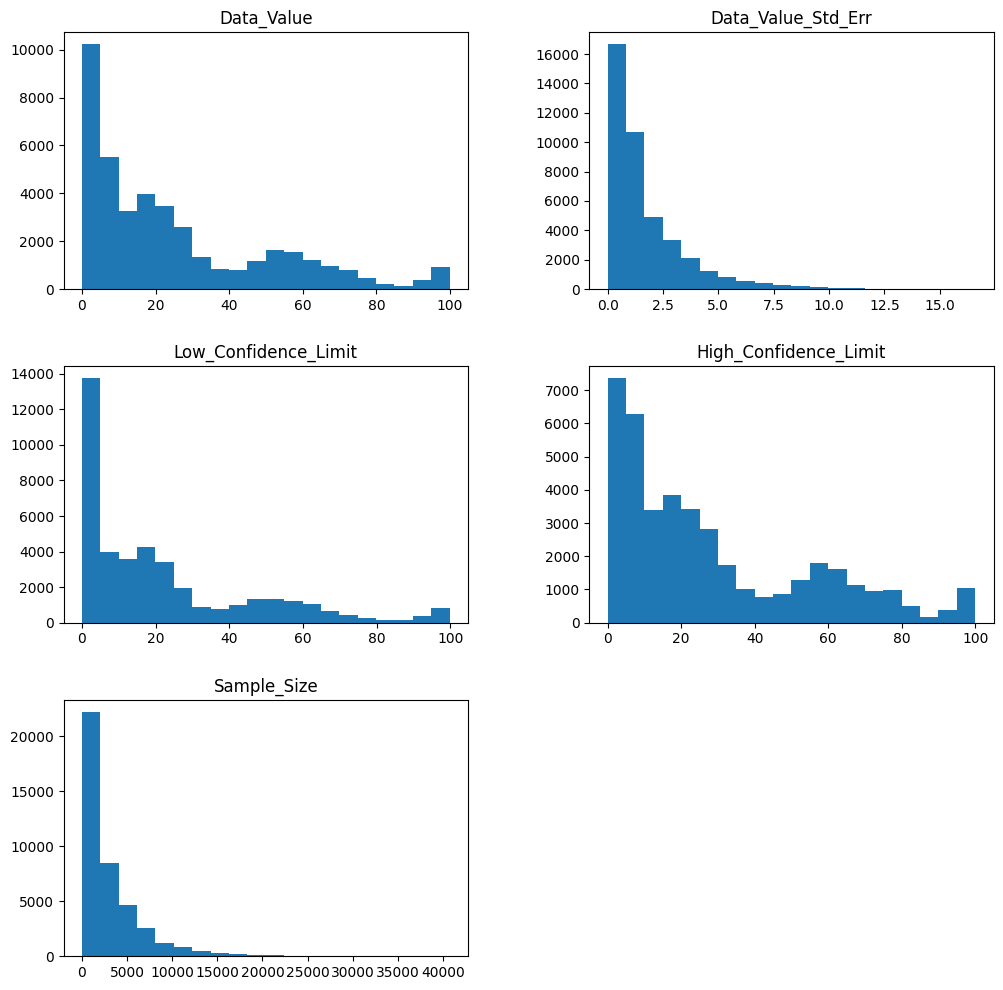

In [14]:
# Histograms distributions of numerical columns
data[numerical_cols].hist(bins=20, figsize=(12,12), grid=False)
plt.show()


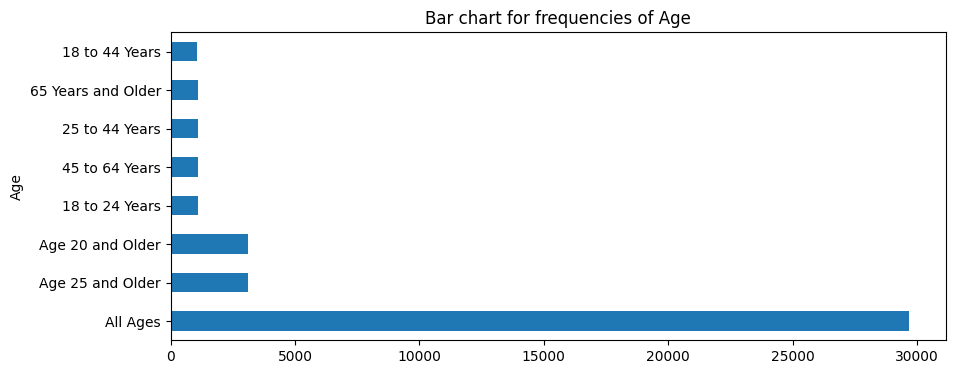

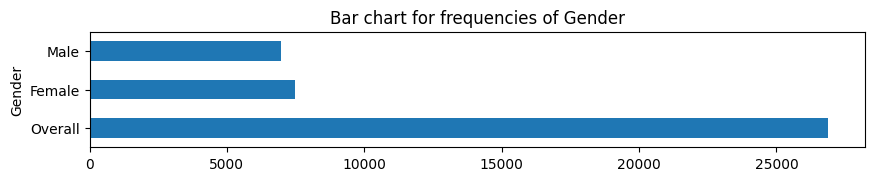

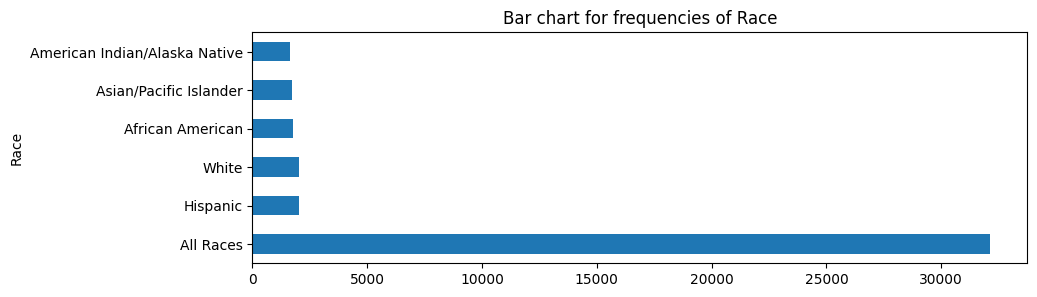

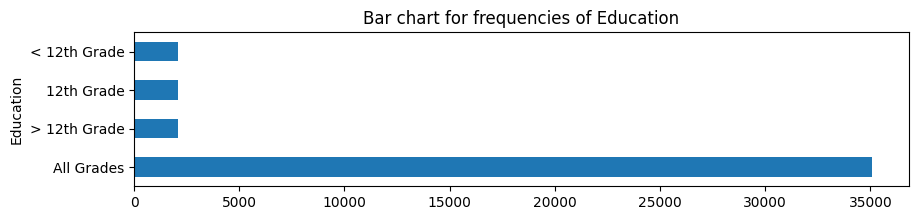

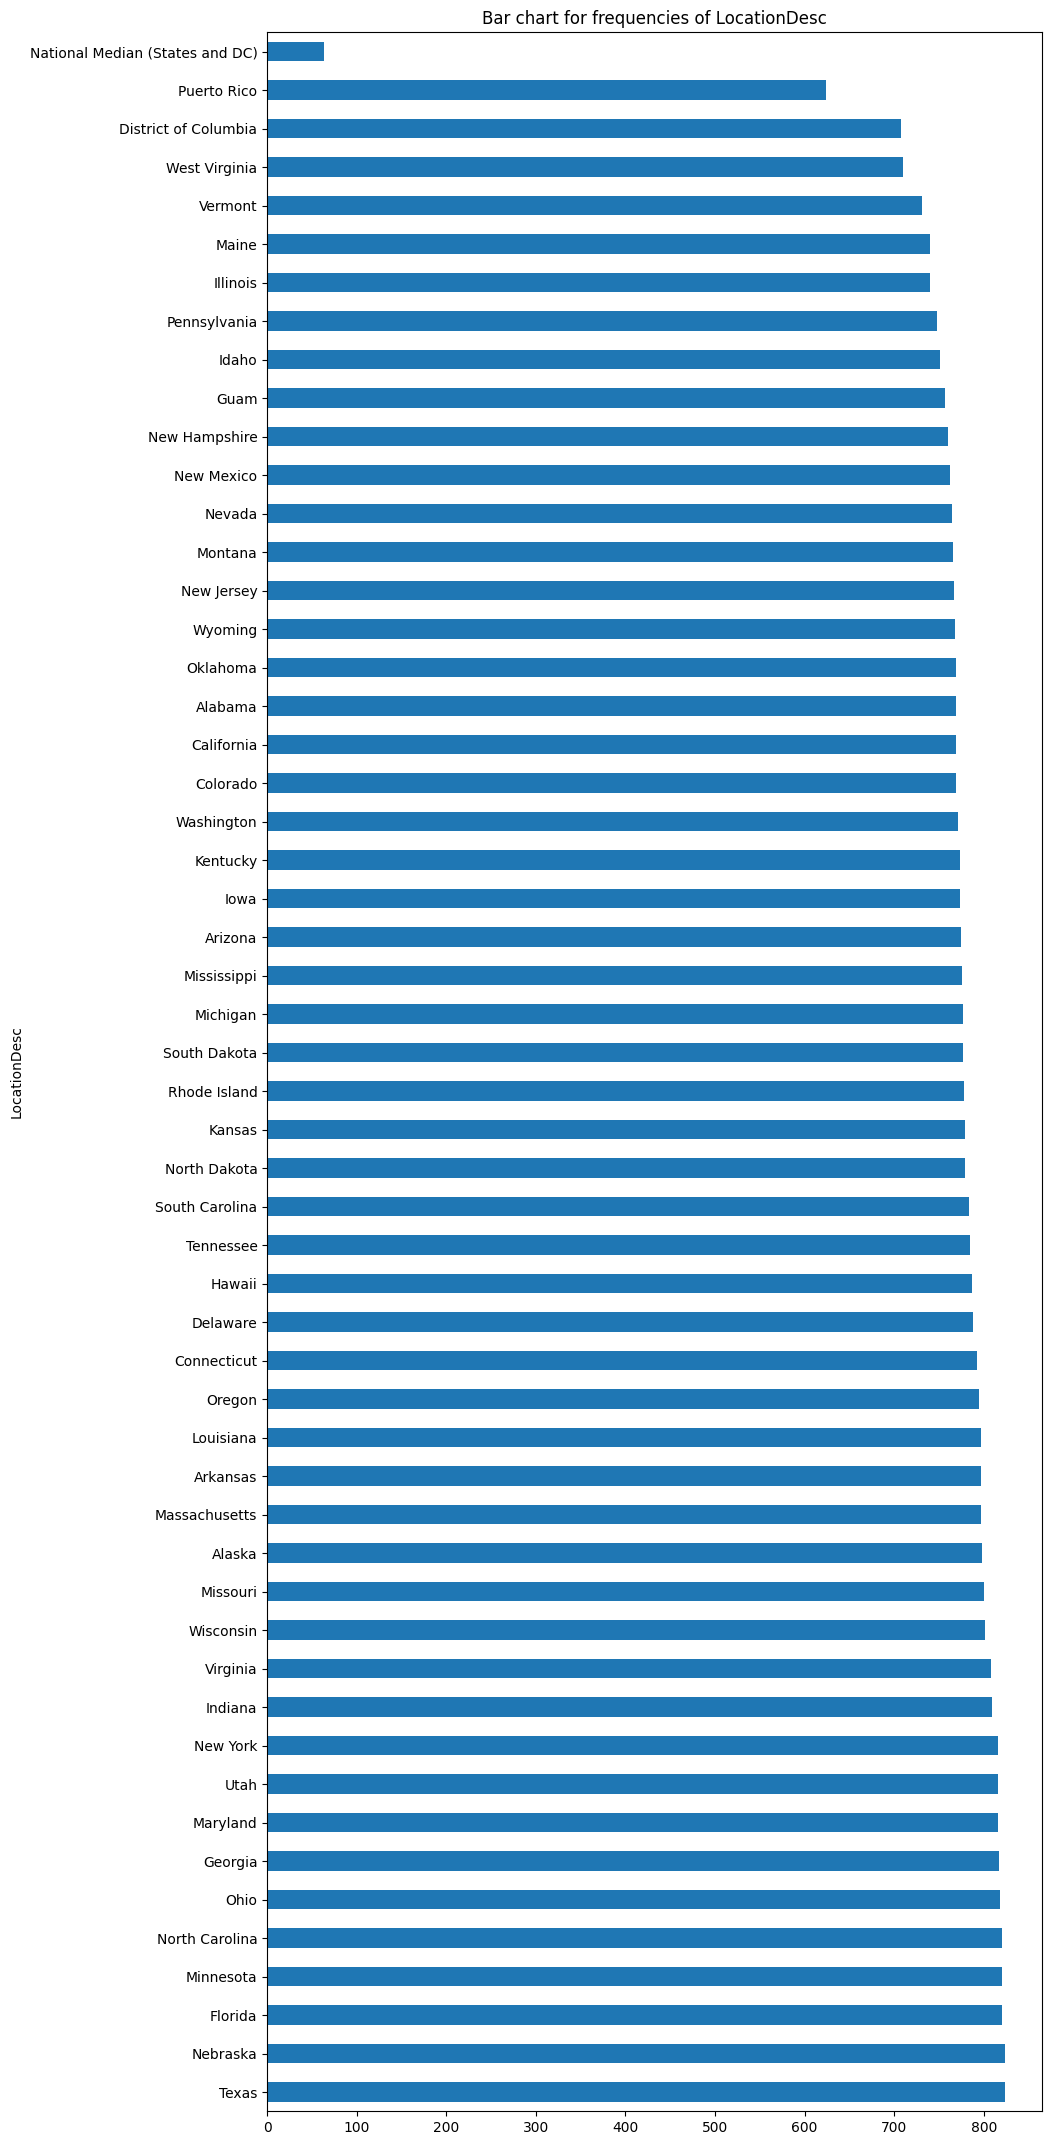

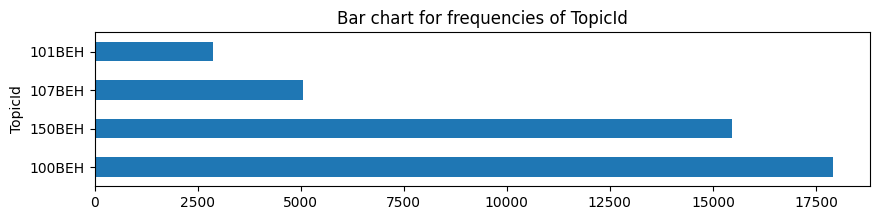

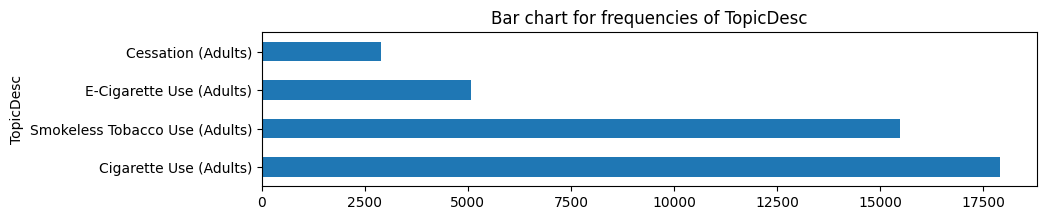

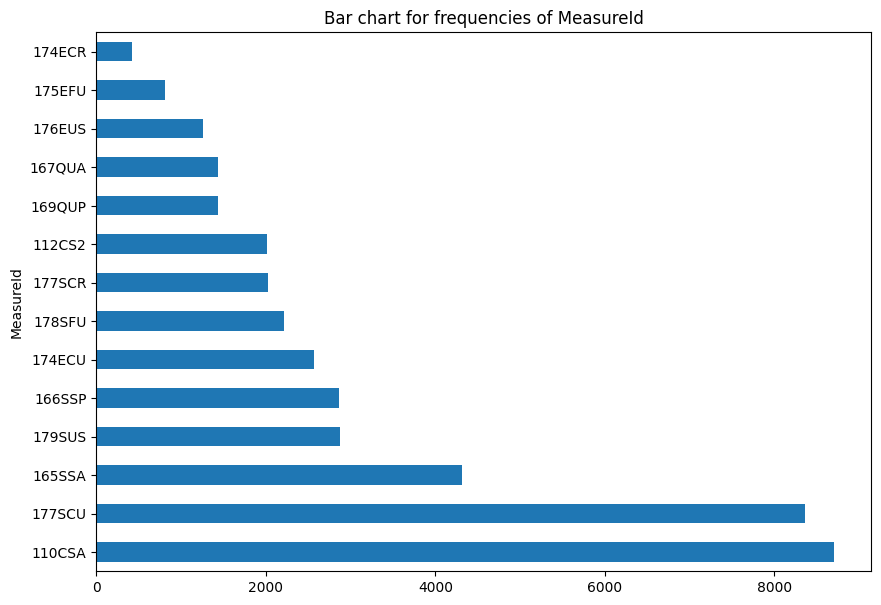

In [15]:
# Horizontal bar chart distributions of categorical columns
for col in categorical_cols:
    freq_table = data[col].value_counts()
    plt.figure(figsize = (10,len(freq_table)*0.5))
    freq_table.plot.barh(title='Bar chart for frequencies of ' + col)
    plt.show()
    print()

In [17]:
# Preprocessing pipeline for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ])


# **SUPPORT VECTOR MACHINES ALGORITHM (SVM)**

In [ ]:
# Define the SVM_pipeline with preprocessing, oversampling, and a SVM classifier
SVM_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),  # Apply preprocessing
    ('oversampler', BorderlineSMOTE(random_state=42)),  # Handle class imbalance
    ('classifier', SVC(
        kernel='rbf',  # Use RBF kernel
        class_weight='balanced',  # Adjust weights for class imbalance
        probability=True,  # Enable probability estimates
        random_state=42
    ))
])

# Split the data into features (X) and target (y)
X = data.drop(columns=target_col)
y = data[target_col]

# Convert target variable to a suitable type for classification
y = y.astype(str)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the SVM_pipeline to the training data
SVM_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Data_Value',
                                                   'Data_Value_Std_Err',
                                                   'Low_Confidence_Limit',
                                                   'High_Confidence_Limit',
                                                   'Sample_Size']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Age', 'Gender', 'Race',
                                                   'Education', 'LocationDesc',
                                                   'TopicId', 'TopicDesc',
                                                   'MeasureId'])])),
                ('oversampler', BorderlineSMOTE(random_state=42)),
                ('classifier',
                 SVC(class_weight='balanced', probability=True,
                     random_state=42))])

In [ ]:
# Make SVM_pipeline on the test data
y_pred = SVM_pipeline.predict(X_test)

# Evaluate the model's performance
print("SVC Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Cross-validation to evaluate the model across multiple splits
scores = cross_val_score(SVM_pipeline, X, y, cv=5, scoring='accuracy')
print(f"SVC Cross-validation accuracy: {scores.mean():.4f}")

SVC Classification Report:
              precision    recall  f1-score   support

     Current       0.97      0.97      0.97       687
   Every Day       0.90      0.91      0.90       564
      Former       0.94      0.93      0.94       366
       Never       1.00      0.99      1.00       367
 Not Current       1.00      1.00      1.00       254
   Some Days       0.91      0.91      0.91       611
     unknown       1.00      1.00      1.00      5416

    accuracy                           0.98      8265
   macro avg       0.96      0.96      0.96      8265
weighted avg       0.98      0.98      0.98      8265

SVC Cross-validation accuracy: 0.9805


# **GRADIENT BOOSTING MACHINES ALGORITHM (GBM)**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Define the GBM_pipeline with preprocessing, oversampling, and a GBM classifier
GBM_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),  # Apply preprocessing
    ('oversampler', BorderlineSMOTE(random_state=42)),  # Handle class imbalance
    ('classifier', GradientBoostingClassifier(
        n_estimators=100,  # Number of boosting stages
        learning_rate=0.1,  # Step size shrinkage
        max_depth=3,  # Maximum depth of individual estimators
        random_state=42  # Random state for reproducibility
    ))
])

# Split the data into features (X) and target (y)
X = data.drop(columns=target_col)
y = data[target_col]

# Convert target variable to a suitable type for classification
y = y.astype(str)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the GBM_pipeline to the training data
GBM_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Data_Value',
                                                   'Data_Value_Std_Err',
                                                   'Low_Confidence_Limit',
                                                   'High_Confidence_Limit',
                                                   'Sample_Size']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Age', 'Gender', 'Race',
                                                   'Education', 'LocationDesc',
                                                   'TopicId', 'TopicDesc',
                                                   'MeasureId'])])),
                ('oversampler', BorderlineSMOTE(random_state=42)),
                ('classifier', GradientBoostingClassifier(random_state=42))])

In [ ]:
# Make GBM_pipeline on the test data
y_pred = GBM_pipeline.predict(X_test)

# Evaluate the model's performance
print("Gradient Boosting Classifier Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Cross-validation to evaluate the model across multiple splits
scores = cross_val_score(GBM_pipeline, X, y, cv=5, scoring='accuracy')
print(f"GBM Cross-validation accuracy: {scores.mean():.4f}")

Gradient Boosting Classifier Report:
              precision    recall  f1-score   support

     Current       0.96      0.96      0.96       687
   Every Day       0.91      0.93      0.92       564
      Former       0.92      0.93      0.92       366
       Never       1.00      1.00      1.00       367
 Not Current       1.00      1.00      1.00       254
   Some Days       0.94      0.91      0.93       611
     unknown       1.00      1.00      1.00      5416

    accuracy                           0.98      8265
   macro avg       0.96      0.96      0.96      8265
weighted avg       0.98      0.98      0.98      8265

GBM Cross-validation accuracy: 0.9804


# **NAIVE BAYES ALGORITHM**

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold

# Update the NB_preprocessor to ensure dense output
NB_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Ensure dense output
        ]), categorical_cols)
    ]
)

# Define the GaussianNB_pipeline with GaussianNB
GaussianNB_pipeline = Pipeline(steps=[
    ('preprocessor', NB_preprocessor),
    ('classifier', GaussianNB())
])

# Split the data into features (X) and target (y)
X = data.drop(columns=target_col)
y = data[target_col]

# Convert target variable to a suitable type for classification
y = y.astype(str)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the GaussianNB_pipeline on the training data
GaussianNB_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Data_Value',
                                                   'Data_Value_Std_Err',
                                                   'Low_Confidence_Limit',
                                                   'High_Confidence_Limit',
                                                   'Sample_Size']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Age', 'Gender', 'Race',
                                                   'Education', 'LocationDesc',
                                                   'TopicId', 'TopicDesc',
                                                   'MeasureId'])])),
                ('classifier', GaussianNB())])

In [ ]:
# Make GaussianNB_pipeline on the test data
y_pred = GaussianNB_pipeline.predict(X_test)

# Evaluate the model's performance
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Calculate ROC AUC Score
print(f"ROC AUC Score: {roc_auc_score(y_test, GaussianNB_pipeline.predict_proba(X_test), multi_class='ovr')}")

# Cross-validation with StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(GaussianNB_pipeline, X, y, cv=cv, scoring='accuracy')

print(f"Naive Bayes Cross-validation accuracy: {scores.mean():.4f}")

Classification Report:
              precision    recall  f1-score   support

     Current       0.99      0.44      0.61       687
   Every Day       0.62      0.65      0.63       564
      Former       0.49      0.99      0.65       366
       Never       0.98      1.00      0.99       367
 Not Current       1.00      0.99      0.99       254
   Some Days       0.66      0.63      0.65       611
     unknown       1.00      1.00      1.00      5416

    accuracy                           0.90      8265
   macro avg       0.82      0.81      0.79      8265
weighted avg       0.92      0.90      0.90      8265

ROC AUC Score: 0.9872588589330193
Naive Bayes Cross-validation accuracy: 0.9018


# **ADABOOST ALGORITHM**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Define the adaboost_pipeline with preprocessing, oversampling, and AdaBoost classifier
adaboost_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),  # Apply preprocessing
    ('oversampler', BorderlineSMOTE(random_state=42)),  # Handle class imbalance
    ('classifier', AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),  # Weak learner
        n_estimators=50,  # Number of weak learners
        learning_rate=1.0,  # Contribution of each weak learner
        algorithm='SAMME',  # Explicitly specify the algorithm
        random_state=42  # For reproducibility
    ))
])

# Split the data into features (X) and target (y)
X = data.drop(columns=target_col)
y = data[target_col]

# Convert target variable to a suitable type for classification
y = y.astype(str)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the adaboost_pipeline to the training data
adaboost_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Data_Value',
                                                   'Data_Value_Std_Err',
                                                   'Low_Confidence_Limit',
                                                   'High_Confidence_Limit',
                                                   'Sample_Size']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Age', 'Gender', 'Race',
                                                   'Education', 'LocationDesc',
                                                   'TopicId', 'TopicDesc',
                                                   'MeasureId'])])),
                ('oversampler', BorderlineSMOTE(random_state=42)),
                ('classifier',
                 AdaBoostClassifier(algorithm='SAMME',
                                    estimator=DecisionTreeClassifier(max_depth=1),
                                    random_state=42))])

In [ ]:
# Make adaboost_pipeline on the test data
y_pred = adaboost_pipeline.predict(X_test)

# Evaluate the model's performance
print("AdaBoost Classifier Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Cross-validation to evaluate the model across multiple splits
scores = cross_val_score(adaboost_pipeline, X, y, cv=5, scoring='accuracy')
print(f"AdaBoost Cross-validation accuracy: {scores.mean():.4f}")

AdaBoost Classifier Report:
              precision    recall  f1-score   support

     Current       0.53      0.44      0.48       687
   Every Day       0.38      0.66      0.48       564
      Former       0.77      0.03      0.05       366
       Never       1.00      0.78      0.87       367
 Not Current       0.46      1.00      0.63       254
   Some Days       0.63      0.04      0.08       611
     unknown       0.88      0.94      0.91      5416

    accuracy                           0.77      8265
   macro avg       0.66      0.56      0.50      8265
weighted avg       0.78      0.77      0.74      8265

AdaBoost Cross-validation accuracy: 0.7270


# **STOCHASTIC GRADIENT DESCENT ALGORITHM (SGD)**

In [ ]:
from sklearn.linear_model import SGDClassifier

# Define the SGD_pipeline with preprocessing, oversampling, and an SGD classifier
SGD_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),  # Apply preprocessing
    ('oversampler', BorderlineSMOTE(random_state=42)),  # Handle class imbalance
    ('classifier', SGDClassifier(
        loss='log_loss',  # Logistic regression for classification
        penalty='l2',  # L2 regularization
        alpha=0.0001,  # Regularization strength
        max_iter=1000,  # Maximum number of iterations
        tol=1e-3,  # Convergence tolerance
        class_weight='balanced',  # Adjust weights for class imbalance
        random_state=42  # For reproducibility
    ))
])

# Split the data into features (X) and target (y)
X = data.drop(columns=target_col)
y = data[target_col]

# Convert target variable to a suitable type for classification
y = y.astype(str)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the SGD_pipeline to the training data
SGD_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Data_Value',
                                                   'Data_Value_Std_Err',
                                                   'Low_Confidence_Limit',
                                                   'High_Confidence_Limit',
                                                   'Sample_Size']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Age', 'Gender', 'Race',
                                                   'Education', 'LocationDesc',
                                                   'TopicId', 'TopicDesc',
                                                   'MeasureId'])])),
                ('oversampler', BorderlineSMOTE(random_state=42)),
                ('classifier',
                 SGDClassifier(class_weight='balanced', loss='log_loss',
                               random_state=42))])

In [ ]:
# Make SGD_pipeline on the test data
y_pred = SGD_pipeline.predict(X_test)

# Evaluate the model's performance
print("SGD Classifier Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Cross-validation to evaluate the model across multiple splits
scores = cross_val_score(SGD_pipeline, X, y, cv=5, scoring='accuracy')
print(f"SGD Cross-validation accuracy: {scores.mean():.4f}")


SGD Classifier Report:
              precision    recall  f1-score   support

     Current       0.87      0.89      0.88       687
   Every Day       0.61      0.86      0.72       564
      Former       0.80      0.75      0.77       366
       Never       0.96      0.99      0.97       367
 Not Current       0.98      1.00      0.99       254
   Some Days       0.81      0.50      0.61       611
     unknown       1.00      1.00      1.00      5416

    accuracy                           0.93      8265
   macro avg       0.86      0.85      0.85      8265
weighted avg       0.94      0.93      0.93      8265

SGD Cross-validation accuracy: 0.9321


# **BAGGING CLASSIFIER ALGORITHM**

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Define the BCA_pipeline with preprocessing, oversampling, and Bagging classifier
BCA_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),  # Apply preprocessing
    ('oversampler', BorderlineSMOTE(random_state=42)),  # Handle class imbalance
    ('classifier', BaggingClassifier(
        estimator=DecisionTreeClassifier(),  # Base learner
        n_estimators=10,  # Number of base estimators
        max_samples=1.0,  # Fraction of the dataset to sample for each base estimator
        max_features=1.0,  # Fraction of features to use for each base estimator
        bootstrap=True,  # Enable bootstrapping
        bootstrap_features=False,  # Disable feature bootstrapping
        random_state=42  # For reproducibility
    ))
])

# Split the data into features (X) and target (y)
X = data.drop(columns=target_col)
y = data[target_col]

# Convert target variable to a suitable type for classification
y = y.astype(str)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the BCA_pipeline to the training data
BCA_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Data_Value',
                                                   'Data_Value_Std_Err',
                                                   'Low_Confidence_Limit',
                                                   'High_Confidence_Limit',
                                                   'Sample_Size']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Age', 'Gender', 'Race',
                                                   'Education', 'LocationDesc',
                                                   'TopicId', 'TopicDesc',
                                                   'MeasureId'])])),
                ('oversampler', BorderlineSMOTE(random_state=42)),
                ('classifier',
                 BaggingClassifier(estimator=DecisionTreeClassifier(),
                                   random_state=42))])

In [ ]:
# Make BCA_pipeline on the test data
y_pred = BCA_pipeline.predict(X_test)

# Evaluate the model's performance
print("Bagging Classifier Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Cross-validation to evaluate the model across multiple splits
scores = cross_val_score(BCA_pipeline, X, y, cv=5, scoring='accuracy')
print(f"Bagging Classifier Cross-validation accuracy: {scores.mean():.4f}")

Bagging Classifier Report:
              precision    recall  f1-score   support

     Current       0.95      0.97      0.96       687
   Every Day       0.88      0.90      0.89       564
      Former       0.95      0.90      0.92       366
       Never       1.00      1.00      1.00       367
 Not Current       1.00      1.00      1.00       254
   Some Days       0.91      0.88      0.90       611
     unknown       1.00      1.00      1.00      5416

    accuracy                           0.98      8265
   macro avg       0.95      0.95      0.95      8265
weighted avg       0.98      0.98      0.98      8265

Bagging Classifier Cross-validation accuracy: 0.9796


# **QUADRATIC DISCRIMINANT ANALYSIS ALGORITHM (QDA)**

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import FunctionTransformer
import numpy as np
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.decomposition import PCA

# Define a function to convert sparse matrices to dense arrays
def dense_converter(X):
    return X.toarray() if hasattr(X, "toarray") else X

# Define the QDA_pipeline with preprocessing, oversampling, PCA, and QDA classifier
QDA_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),  # Apply preprocessing
    ('oversampler', BorderlineSMOTE(random_state=42)),  # Handle class imbalance
    ('to_dense', FunctionTransformer(dense_converter)),  # Convert sparse to dense
    ('pca', PCA(n_components=10)),  # Apply PCA for dimensionality reduction
    ('classifier', QuadraticDiscriminantAnalysis())  # QDA classifier without shrinkage
])

# Split the data into features (X) and target (y)
X = data.drop(columns=target_col)
y = data[target_col]

# Convert target variable to a suitable type for classification
y = y.astype(str)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the QDA_pipeline to the training data
QDA_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Data_Value',
                                                   'Data_Value_Std_Err',
                                                   'Low_Confidence_Limit',
                                                   'High_Confidence_Limit',
                                                   'Sample_Size']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Age', 'Gender', 'Race',
                                                   'Education', 'LocationDesc',
                                                   'TopicId', 'TopicDesc',
                                                   'MeasureId'])])),
                ('oversampler', BorderlineSMOTE(random_state=42)),
                ('to_dense',
                 FunctionTransformer(func=<function dense_converter at 0x7cb434949480>)),
                ('pca', PCA(n_components=10)),
                ('classifier', QuadraticDiscriminantAnalysis())])

In [ ]:
# Make QDA_pipeline on the test data
y_pred = QDA_pipeline.predict(X_test)

# Evaluate the model's performance
print("QDA Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Cross-validation to evaluate the model across multiple splits
scores = cross_val_score(QDA_pipeline, X, y, cv=5, scoring='accuracy')
print(f"QDA Cross-validation accuracy: {scores.mean():.4f}")

QDA Classification Report:
              precision    recall  f1-score   support

     Current       0.88      0.72      0.79       687
   Every Day       0.86      0.71      0.78       564
      Former       0.61      0.81      0.70       366
       Never       0.98      0.89      0.94       367
 Not Current       1.00      0.81      0.89       254
   Some Days       0.80      0.79      0.79       611
     unknown       0.97      1.00      0.98      5416

    accuracy                           0.92      8265
   macro avg       0.87      0.82      0.84      8265
weighted avg       0.92      0.92      0.92      8265

QDA Cross-validation accuracy: 0.9295


# **MULTI-LAYER PERCEPTRON ALGORITHM (MLP)**

In [18]:
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.neural_network import MLPClassifier

# Define the MLP_pipeline with preprocessing, oversampling, and MLP classifier
MLP_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),  # Apply preprocessing
    ('oversampler', BorderlineSMOTE(random_state=42)),  # Handle class imbalance
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(100, 50),  # Two hidden layers with 100 and 50 neurons
        activation='relu',  # Activation function
        solver='adam',  # Optimizer
        max_iter=300,  # Maximum number of iterations
        random_state=42,  # Seed for reproducibility
        early_stopping=True  # Stop if validation score stops improving
    ))
])

# Split the data into features (X) and target (y)
X = data.drop(columns=target_col)
y = data[target_col]

# Convert target variable to a suitable type for classification
y = y.astype(str)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the MLP_pipeline to the training data
MLP_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Data_Value',
                                                   'Data_Value_Std_Err',
                                                   'Low_Confidence_Limit',
                                                   'High_Confidence_Limit',
                                                   'Sample_Size']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Age', 'Gender', 'Race',
                                                   'Education', 'LocationDesc',
                                                   'TopicId', 'TopicDesc',
                                                   'MeasureId'])])),
                ('oversampler', BorderlineSMOTE(random_state=42)),
                ('classifier',
                 MLPClassifier(early_stopping=True,
                               hidden_layer_sizes=(100, 50), max_iter=300,
                               random_state=42))])

In [19]:
# Make MLP_pipeline on the test data
y_pred = MLP_pipeline.predict(X_test)

# Evaluate the model's performance
print("MLP Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Cross-validation to evaluate the model across multiple splits
scores = cross_val_score(MLP_pipeline, X, y, cv=5, scoring='accuracy')
print(f"MLP Cross-validation accuracy: {scores.mean():.4f}")

MLP Classification Report:
              precision    recall  f1-score   support

     Current       0.97      0.99      0.98       687
   Every Day       0.90      0.87      0.89       564
      Former       0.98      0.94      0.96       366
       Never       1.00      1.00      1.00       367
 Not Current       1.00      1.00      1.00       254
   Some Days       0.88      0.91      0.90       611
     unknown       1.00      1.00      1.00      5416

    accuracy                           0.98      8265
   macro avg       0.96      0.96      0.96      8265
weighted avg       0.98      0.98      0.98      8265

MLP Cross-validation accuracy: 0.9818


# Result summary

## Summarizing all models' performances in the table below

|Model                                  |Tobacco Use | f1-score| accuracy|
|---------------------------------------|------------|---------|---------|
|SUPPORT VECTOR MACHINES ALGORITHM (SVM)|            |         |0.9805   |
|                                       |Current     |0.97     |         |
|                                       |Every Day   |0.90     |         |
|                                       |Former      |0.94     |         |
|                                       |Never       |1.00     |         |
|                                       |Not Current |1.00     |         |
|                                       |Some Days   |0.91     |         |
|---------------------------------------|------------|---------|---------|
|GRADIENT BOOSTING MACHINES ALGORITHM   |            |         |0.9804   |
|                                       |Current     |0.96     |         |
|                                       |Every Day   |0.92     |         |
|                                       |Former      |0.92     |         |
|                                       |Never       |1.00     |         |
|                                       |Not Current |1.00     |         |
|                                       |Some Days   |0.93     |         |
|---------------------------------------|------------|---------|---------|
|NAIVE BAYES ALGORITHM                  |            |         |0.9018   |
|                                       |Current     |0.61     |         |
|                                       |Every Day   |0.63     |         |
|                                       |Former      |0.65     |         |
|                                       |Never       |0.99     |         |
|                                       |Not Current |0.99     |         |
|                                       |Some Days   |0.65     |         |
|---------------------------------------|------------|---------|---------|
|ADABOOST ALGORITHM                     |            |         |0.7270   |
|                                       |Current     |0.48     |         |
|                                       |Every Day   |0.48     |         |
|                                       |Former      |0.05     |         |
|                                       |Never       |0.87     |         |
|                                       |Not Current |0.63     |         |
|                                       |Some Days   |0.08     |         |
|---------------------------------------|------------|---------|---------|

|Model                                  |Tobacco Use | f1-score| accuracy|
|---------------------------------------|------------|---------|---------|
|STOCHASTIC GRADIENT DESCENT ALGORITHM  |            |         |0.9321   |
|                                       |Current     |0.88     |         |
|                                       |Every Day   |0.72     |         |
|                                       |Former      |0.77     |         |
|                                       |Never       |0.97     |         |
|                                       |Not Current |0.99     |         |
|                                       |Some Days   |0.61     |         |
|---------------------------------------|------------|---------|---------|
|BAGGING CLASSIFIER ALGORITHM           |            |         |0.9796   |
|                                       |Current     |0.96     |         |
|                                       |Every Day   |0.89     |         |
|                                       |Former      |0.92     |         |
|                                       |Never       |1.00     |         |
|                                       |Not Current |1.00     |         |
|                                       |Some Days   |0.90     |         |
|---------------------------------------|------------|---------|---------|
|QUADRATIC DISCRIMINANT ANALYSIS (QDA)  |            |         |0.9295   |
|                                       |Current     |0.79     |         |
|                                       |Every Day   |0.78     |         |
|                                       |Former      |0.70     |         |
|                                       |Never       |0.94     |         |
|                                       |Not Current |0.89     |         |
|                                       |Some Days   |0.79     |         |
|---------------------------------------|------------|---------|---------|
|MULTI-LAYER PERCEPTRON ALGORITHM (MLP) |            |         |0.9818   |
|                                       |Current     |0.98     |         |
|                                       |Every Day   |0.89     |         |
|                                       |Former      |0.96     |         |
|                                       |Never       |1.00     |         |
|                                       |Not Current |1.00     |         |
|                                       |Some Days   |0.90     |         |
|---------------------------------------|------------|---------|---------|


## In conclusion, the performance of various machine learning algorithms for predicting tobacco use shows notable differences in f1-scores  and cross-validation accuracy. The Support Vector Machines (SVM) and Gradient Boosting Machines (GBM) algorithms performed similarly, with cross-validation accuracy of 0.9805 and 0.9804, respectively, achieving high accuracy across most tobacco use categories. The Multi-Layer Perceptron (MLP) also showed strong results, with a cross-validation accuracy of 0.9818, making it the top performer overall. On the other hand, algorithms such as Naive Bayes and AdaBoost exhibited weaker performance, especially for categories like "Current" and "Every Day." Despite their lower cross-validation accuracy, some models, like Stochastic Gradient Descent (SGD), and Bagging Classifier, showed balanced performance across all categories. Ultimately, the SVM, GBM, and MLP algorithms stand out as the most effective for predicting tobacco use, with SVM and MLP offering slightly better overall precision.